### Linear Discriminant Analysis (Unsupervised Dimensionality Reduction)

let's summarize the approach in a few simple steps:
1. Standardize the d-dimensional dataset (d is the number of features).
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter matrix $S_B$ and the within-class scatter matrix $S_W$.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix $S_W^{− 1} S_{B}$.
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a ${d \times k}$ dimensional transformation matrix $W$; the eigenvectors are the columns of this matrix.
7. Project the samples onto the new feature subspace using the transformation matrix W.

*Note: As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues and eigenvectors, which will form the new lower- dimensional feature space. However, as mentioned before, LDA takes class label information into account, which is represented in the form of the mean vectors computed in step 2.*

# Terminology

Mean feature value with respect to the samples of class $i$:

\begin{aligned}
    m_i = \frac{1}{n_i}\sum_{x \in D_i}^{c}\bf{x_m}
\end{aligned}

$m_i$ for wine dataset:

\begin{aligned}
m_i =  \begin{bmatrix}
\mu_{i,\ alcohol}\\
\mu_{i,\ malic \ acid}\\
...\\
\mu_{i,\ proline}\\
\end{bmatrix}
  \ ; i \in \{1, 2, 3\}
\end{aligned}

*Note: So for 3 class we will have 3 mean vectors for all dimention.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 12

### Read the Data

In [21]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [22]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [23]:
np.set_printoptions(precision=4)

### Transform the Data and Find the Eigen Values and Vectors

In [5]:
from sklearn.model_selection import train_test_split

In [32]:
features, targets = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [33]:
feat_train, feat_test, tar_train, tar_test = train_test_split(
    features, targets, 
    test_size=0.3, 
    stratify=targets, 
    random_state=0
)

In [34]:
#standardize the features
from sklearn.preprocessing import StandardScaler

In [9]:
sc = StandardScaler()
feat_train_std = sc.fit_transform(feat_train)
feat_test_std = sc.transform(feat_test)

### Calculating the Mean Vectors

In [10]:
mean_vecs = []
for label in range(1, 4):
    # collapse the vertical dimention with axis=0
    # column wise mean
    mean_vecs.append(np.mean(feat_train_std[tar_train==label], axis=0)) 
    print("MV {}: {}".format(label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


Using the mean vectors, we can now compute the within-class scatter matrix $S_W$ :

\begin{aligned}
    S_W = \sum_{i = 1}^{c} S_i \ i = 1, 2, 3
\end{aligned}

This is calculated by summing up the individual scatter matrices $S_i$ of each individual class $i$:

\begin{aligned}
    S_i = \sum_{x \in D_{i}}^{c} (x-m_i)(x-m_i)^T
\end{aligned}

In [35]:
d = 13 # number of features

In [36]:
S_W = np.zeros((d, d))

In [38]:
for label, mv in zip(range(1, 4), mean_vecs):
    unit_squared_deviation = np.zeros((d, d))
    for row in feat_train_std[tar_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        unit_squared_deviation += (row - mv).dot((row - mv).T)
    S_W += unit_squared_deviation # sum class scatter matrices

In [39]:
print('Within-class scatter matrix: {} x {}'.format(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13 x 13


As the class labels are not uniformly distributed so we need to normalized the results with sample size. Which turn out to be coveriance metrix.

\begin{aligned}
    S_i = \frac{1}{n_i}\sum_{x \in D_{i}}^{c} (x-m_i)(x-m_i)^T
\end{aligned}

In [40]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    unit_squared_deviation = np.cov(feat_train_std[tar_train == label].T)
    S_W += unit_squared_deviation

we can move on to the next step and compute the between-class scatter matrix $S_B$:

\begin{aligned}
    S_B = \sum_{i}^{c} n_i(m_i - m)(m_i - m)^T
\end{aligned}

In [15]:
mean_overall = np.mean(feat_test_std, axis=0) # collaplse the vertical axis/keep the horizonta axis
d = 13

In [41]:
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n_i = feat_train[tar_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n_i * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between Class Matrix {} x {}'.format(S_B.shape[0], S_B.shape[1]))

Between Class Matrix 13 x 13


In [42]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [45]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.76152218979385
2.902486757115975e-14
2.842170943040401e-14
1.8792598864684247e-14
1.8792598864684247e-14
1.570137094529844e-14
1.570137094529844e-14
6.116988201454594e-15
5.6936028514646926e-15
5.6936028514646926e-15
4.663614910753138e-15
1.3177428408410096e-15


### Find the Eigen Vectors with Highest Variance

In [47]:
tot = sum(eigen_vals.real)
discr = [i/tot for i in sorted(eigen_vals, reverse=True)]
cum_discr = np.cumsum(discr)

/home/datapsycho/PycharmProjects/StatBase/venv/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/datapsycho/PycharmProjects/StatBase/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


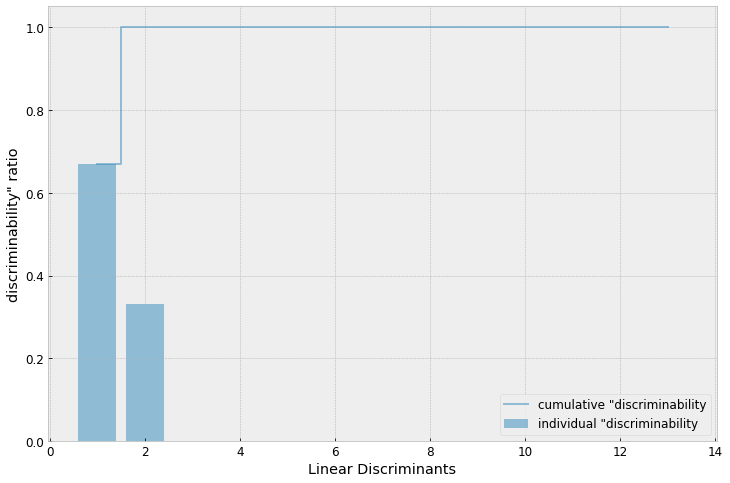

In [48]:
plt.figure(figsize=(12, 8))
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability')
plt.step(range(1, 14), cum_discr, alpha=0.5, where='mid', label='cumulative "discriminability')
plt.ylabel('discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.legend(loc='best')

In [49]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [50]:
eigen_pairs[:3]

[(349.617808905994,
  array([-0.1481+0.j,  0.0908+0.j, -0.0168+0.j,  0.1484+0.j, -0.0163+0.j,
          0.1913+0.j, -0.7338+0.j, -0.075 +0.j,  0.0018+0.j,  0.294 +0.j,
         -0.0328+0.j, -0.3547+0.j, -0.3915+0.j])),
 (172.76152218979385,
  array([-0.4092+0.j, -0.1577+0.j, -0.3537+0.j,  0.3223+0.j, -0.0817+0.j,
          0.0842+0.j,  0.2823+0.j, -0.0102+0.j,  0.0907+0.j, -0.2152+0.j,
          0.2747+0.j, -0.0124+0.j, -0.5958+0.j])),
 (2.902486757115975e-14,
  array([ 0.2273+0.j,  0.22  +0.j,  0.151 +0.j, -0.2991+0.j,  0.0068+0.j,
         -0.4317+0.j, -0.3542+0.j,  0.036 +0.j,  0.0703+0.j,  0.0237+0.j,
          0.2292+0.j,  0.6144+0.j, -0.1973+0.j]))]

In [51]:
# Add a new dimention to each vector for stacking
eigen_pairs[0][1][:, np.newaxis]

array([[-0.1481+0.j],
       [ 0.0908+0.j],
       [-0.0168+0.j],
       [ 0.1484+0.j],
       [-0.0163+0.j],
       [ 0.1913+0.j],
       [-0.7338+0.j],
       [-0.075 +0.j],
       [ 0.0018+0.j],
       [ 0.294 +0.j],
       [-0.0328+0.j],
       [-0.3547+0.j],
       [-0.3915+0.j]])

In [52]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

In [53]:
w

array([[-0.1481, -0.4092],
       [ 0.0908, -0.1577],
       [-0.0168, -0.3537],
       [ 0.1484,  0.3223],
       [-0.0163, -0.0817],
       [ 0.1913,  0.0842],
       [-0.7338,  0.2823],
       [-0.075 , -0.0102],
       [ 0.0018,  0.0907],
       [ 0.294 , -0.2152],
       [-0.0328,  0.2747],
       [-0.3547, -0.0124],
       [-0.3915, -0.5958]])

*Note: By executing the preceding code, we have created a 13 x 2-dimensional projection matrix W from the top two eigenvectors.*

Using the projection matrix, we can now transform a sample x (represented as a 1 x 13-dimensional row vector) onto the LDA subspace (the Linear Discriminant one and two) obtaining $x^{'}$ , now a two-dimensional sample vector consisting of two new features:

\begin{align}
    x^{'} = xW
\end{align}

Similarly, we can transform the entire 124 x 13-dimensional training dataset onto the two principal components by calculating the matrix dot product:

\begin{align}
    X^{'} = XW
\end{align}

In [54]:
feat_train_lda = feat_train_std.dot(w)

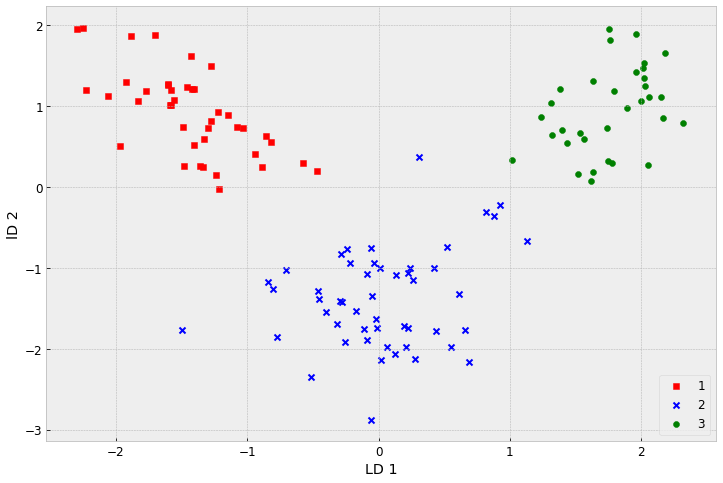

In [56]:
plt.figure(figsize=(12, 8))
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(tar_train), colors, markers):
    plt.scatter(
        feat_train_lda[tar_train==l, 0],
        feat_train_lda[tar_train==l, 1] * -1,
        c=c, label=l, marker=m
    )
plt.xlabel('LD 1')
plt.ylabel('lD 2')
plt.legend(loc='lower right')

### LDA in Scikit-learn

In [57]:
from neuralbase import plot_decision_regions

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [59]:
from sklearn.linear_model import LogisticRegression

In [66]:
lda = LDA(n_components=2)
feat_train_lda = lda.fit_transform(X_train_std, y_train)

In [67]:
lr = LogisticRegression(multi_class='auto', solver='lbfgs')
lr.fit(feat_train_lda, tar_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Text(0.5, 1.0, 'Decision Region for Train Data')

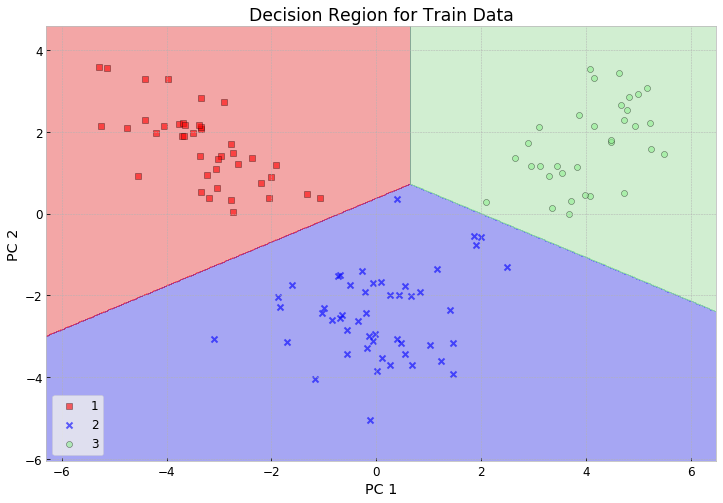

In [68]:
plt.figure(figsize=(12, 8))
plot_decision_regions(feat_train_lda, tar_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.title("Decision Region for Train Data")

Text(0.5, 1.0, 'Decision Region for Test Data')

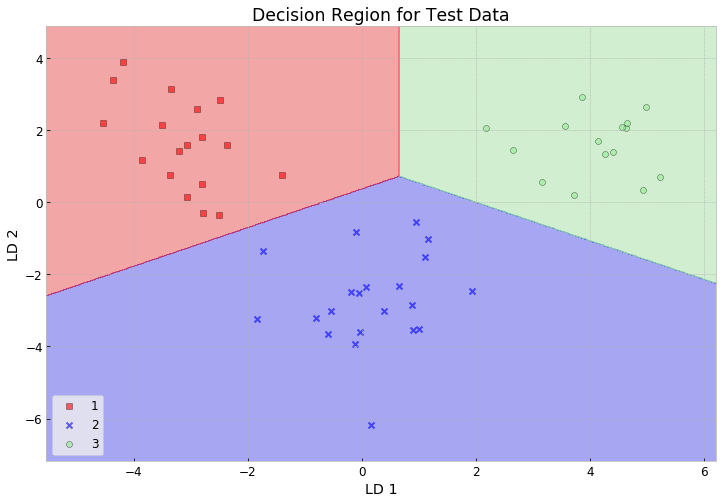

In [69]:
feat_test_lda = lda.transform(feat_test_std)
plt.figure(figsize=(12, 8))
plot_decision_regions(feat_test_lda, tar_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title("Decision Region for Test Data")

#### Example Operation

In [28]:
a = np.array([[10, 20], [20, 40], [30, 40]])

In [38]:
# convert each row vector to column natrix
for row in a:
    row = row.reshape(d, 1)
    print(row)

[[10]
 [20]]
[[20]
 [40]]
[[30]
 [40]]


In [30]:
# collapsing the vertical axis
test_mean_vec = np.mean(a, axis=0) 
test_mean_vec

array([20.    , 33.3333])

In [44]:
# Convert row vector to Column Matrix
test_mean_vec.reshape(d, 1)

array([[20.    ],
       [33.3333]])

In [31]:
d = 2
S_W = np.zeros((d, d))

In [32]:
S_W

array([[0., 0.],
       [0., 0.]])

In [52]:
for row in a:
    # reshape to d by 1 each row
    row = row.reshape(d, 1)
    # calculate the mean deviation for each row
    within_group = row - test_mean_vec.reshape(d, 1)
    # calculate squared deviation for each sample
    squared_deviation = within_group.dot(within_group.T)

[[100.     133.3333]
 [133.3333 177.7778]]
[[ 0.      0.    ]
 [ 0.     44.4444]]
[[100.      66.6667]
 [ 66.6667  44.4444]]
